In [1]:
using JLD, Plots
using HDF5
using Base.Iterators
gr()

Plots.GRBackend()

In [2]:
arxname="../JLDFiles/Evocada/control1/LFP_Promedio_est_con5.jld"
datos=load(arxname)
csd=datos["kCSDCorrecta"]
freq=datos["freq"]
retr=datos["retrazo"]
lat=datos["latencia"]
cresp=datos["Canalesrespuesta"]
csatu=datos["CanalesSaturados"]

Set(Array{Int64,1}[[11, 63], [29, 55], [7, 46], [14, 15], [23, 19], [55, 35], [15, 43], [31, 46], [1, 1], [44, 23]  …  [6, 37], [56, 51], [13, 22], [37, 14], [9, 33], [13, 45], [10, 38], [9, 43], [13, 20], [54, 55], [1, 12]])

In [3]:
(h,w,nmax)=size(csd)
epsi=21
  ss=[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [4]:
size(csd)

(64, 64, 1163)

In [12]:
retr+lat+3*freq

170.56650615657293

In [13]:
maximum(csd[:,:,117:end])

581.7767582987807

In [14]:
keys(datos)

Base.KeySet for a Dict{String,Any} with 10 entries. Keys:
  "Canalesrespuesta"
  "KTT_KInv"
  "freq"
  "latencia"
  "kCSDCorrecta"
  "retrazo"
  "Nota"
  "LFPSaturados"
  "final"
  "CanalesSaturados"

In [15]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [16]:
csdsymb=map(x->simboliza(x), csd);

In [17]:
xs=csdsymb[16,28,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [18]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [19]:
function ncartprod(ss, n)
    argumento=ntuple(i->ss, n)
    result=product(argumento...)
    return(result)
end

ncartprod (generic function with 1 method)

In [20]:
# con permiso de StackOverflow oooo.key takes lot to compile!
issubvec(v,big) = any([v == big[i:(i+length(v)-1)] for i=1:(length(big)-length(v)+1)])

issubvec (generic function with 1 method)

In [21]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        aux=problock(xxs, pr)
        if aux>0
            result[pr]= aux
        else
            push!(malas, pr)
        end
    end
    return (result, malas)
end


function allprobsn(xxs, ss, n, vacias)
    
    #ush tambien muy ineficiente. Sigue siendo mejor buscar a lo pendejo???
            result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        tanteada=any(issubvec(v, pr) for v in vacias)
        if tanteada
         #   print(pr, " esta tanteada!!  ")
            aux=0
        else
            aux=problock(xxs, pr)
            if aux>0
                result[pr]= aux
            else
                push!(malas, pr)
            end
        end # sobre tanteada
    end #sobre palabras
    return (result, malas)
end

allprobsn (generic function with 2 methods)

Haciendo pruebas, al parecer matar el conjunto de malas con entre 3 y 4 letras es la forma más rapida. Ya despues de eso tiene que revisar palabrerias tan largas que no conviene.

In [22]:
@time (p, v3)=allprobsn(xs, ss, 3)

  0.353272 seconds (854.37 k allocations: 44.892 MiB, 4.07% gc time)


(Dict{Array,Float64}([-1, -1, 0]=>0.000861326,[0, -1, -1]=>0.000861326,[0, 0, 0]=>0.953488,[0, -1, 0]=>0.00172265,[-1, 0, 0]=>0.00258398,[1, 0, 0]=>0.000861326,[0, 0, -1]=>0.00258398,[-1, -1, -1]=>0.0353144,[0, 0, 1]=>0.000861326,[0, 1, 0]=>0.000861326…), Set(Any[[1, -1, -1], [-1, 1, 1], [-1, 1, 0], [-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, -1, 1], [1, 1, 1], [1, -1, 0], [0, 1, -1], [-1, 0, 1], [1, -1, 1], [1, 1, -1], [1, 1, 0], [0, -1, 1], [-1, 1, -1], [0, 1, 1]]))

In [23]:
@time (p, v)=allprobsn(xs, ss, 11)

 24.188926 seconds (206.22 M allocations: 33.655 GiB, 40.48% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1]=>0.000867303,[-1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.000867303,[-1, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]=>0.000867303,[0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1]=>0.000867303,[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]=>0.028621,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000867303,[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.00173461…), Set(Any[[-1, -1, -1, -1, -1, -1, -1, 1, 0, 1, -1], [1, -1, 0, -1, 1, -1, 1, -1, 1, 0, 0], [-1, 0, -1, 0, 0, 0, -1, 0, -1, 1, 0], [1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1], [1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [-1, -1, 0, 0, -1, -1, -1, 0, 1, 1, -1], [-1, 0, 0, -1, -1, -1, 1, 0, 1, 1, 0], [1, -1, 0, 1, 1, 0, 1, 1, 1, 0, -1], [-1, -1, -1, 0, 1, 0, 0, 1, 1, 1, 0], [-1, 1, -1, 0, 1, 1, -1, 0, 0, 0, 1]  …  [1, 0, -1, 0, 0, 1, 0, 0, -1, -1, -1], [0, 1, 1, -1, -1, 0, 1, -1, -1, -1, -1

In [24]:
length(v3)

17

In [41]:
@time (ar, ir)=allprobsn(xs, ss,11, v3)

  1.076222 seconds (10.03 M allocations: 1.071 GiB, 30.01% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1]=>0.000867303,[-1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]=>0.000867303,[-1, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]=>0.000867303,[0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1]=>0.000867303,[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]=>0.028621,[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]=>0.000867303,[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]=>0.000867303,[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]=>0.00173461…), Set(Any[[0, 0, 0, -1, -1, -1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0], [-1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 1], [0, -1, 0, 0, 0, 1, 0, 0, 0, -1, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, -1, 0, 0, 1, 0, 0, -1, -1], [0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0], [-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, -1, 0, 0, -1, -1, 0, 0, -1, -1, -1]  …  [0, 1, 0, 0, 0, -1, -1, 0, 0, -1, -1], [-1, -1, -1, -1, 0, 0, -1, -1, -1, 0, 0], [0, 0, 0, -

In [25]:
function shanonH_n(xxs, ss, n)
    (probs, v)=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(xxs, ss, n, v)
    (probs, v)=allprobsn(xxs,ss,n, v)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(probs,n)
    #meter un dict con probs>0 porfis
    h=0
    for q in values(probs)
        h+=q*log(q)
    end
    result=-h/n
    return result
end

shanonH_n (generic function with 3 methods)

In [27]:
lmax=length(cresp)

359

In [28]:
log(3, nmax)

6.425158561694472

In [29]:
hhsn=Dict{Array{Int, 1}, Array{Float64,1}}()
hhsn2=Dict{Array{Int, 1}, Array{Float64,1}}()
arbol=Dict{Array{Int,1}, Dict{Int, Array}}()
nn=7
@time for c in cresp
        reng=c[1]
        col=c[2]
        xs=csdsymb[reng,col,:]
        hhsn[c]=zeros(nn)
        arbol[c]=Dict{Int, Array}()
    for n=1:nn
            v=Set()
        if n<4
            probs, v= allprobsn(xs, ss,n)
        else
            probs, v2= allprobsn(xs, ss,n, v)
        end
            buenas=collect(keys(probs))
            arbol[[reng, col]][n]=buenas
        hhsn[[reng,col]][n]=shanonH_n(probs,n)
            
    end

    
end


123.869199 seconds (1.37 G allocations: 175.881 GiB, 33.86% gc time)


In [30]:
sum3n(n)=Int32(3/2*(-1+3^n))

sum3n (generic function with 1 method)

In [33]:
function trescodifica(xxs)
    #Convierte tus strings raros en un entero como si fuera ternario
    # con las cifras 0,1,2 (que son las que tienes +1)
    ll=length(xxs)
    r=0
    for j=1:ll
       a=xxs[j]+1
       r+=3^(ll-j)*a
    end
    return r
end

trescodifica (generic function with 1 method)

In [43]:
function codanumero(xxs)
    ll=length(xxs)
    naux=sum3n(ll-1)
    bla=trescodifica(xxs)
    r=bla+naux+1 # la raiz en realidad es "ningun signo"
    return r
end

codanumero (generic function with 1 method)

In [44]:
bl=[-1,-1,0,1,0]

5-element Array{Int64,1}:
 -1
 -1
  0
  1
  0

In [45]:
codanumero(bl)

137

In [46]:
trescodifica(bl)

16

In [74]:
nredu

4

In [47]:
arbex=arbol[[23,43]]
for a in arbol[[23,43]][2]
    print(a, " ")
end

[0, -1] [-1, 0] [-1, -1] [0, 0] [1, 0] [1, -1] [1, 1] [0, 1] 

In [81]:
nredu=3
nodosmax=sum3n(nredu)
adja=zeros(Int8,nodosmax,nodosmax);
println(nodosmax)

39


In [82]:
for n=1:nredu-1
    for a in arbex[n]
        acode=codanumero(a)
        for b in arbex[n+1]
            bcode=codanumero(b)
            if a==b[1:end-1] # si b proviene de a mas un sufijo 
                print("a=",a, " b=",b, " acode=", acode, " bcode=",bcode, ". \n")
                adja[acode,bcode]=1
            end
        end
    end
end



a=[1] b=[1, 0] acode=3 bcode=11. 
a=[1] b=[1, -1] acode=3 bcode=10. 
a=[1] b=[1, 1] acode=3 bcode=12. 
a=[-1] b=[-1, 0] acode=1 bcode=5. 
a=[-1] b=[-1, -1] acode=1 bcode=4. 
a=[0] b=[0, -1] acode=2 bcode=7. 
a=[0] b=[0, 0] acode=2 bcode=8. 
a=[0] b=[0, 1] acode=2 bcode=9. 
a=[0, -1] b=[0, -1, -1] acode=7 bcode=22. 
a=[0, -1] b=[0, -1, 0] acode=7 bcode=23. 
a=[-1, 0] b=[-1, 0, -1] acode=5 bcode=16. 
a=[-1, 0] b=[-1, 0, 1] acode=5 bcode=18. 
a=[-1, 0] b=[-1, 0, 0] acode=5 bcode=17. 
a=[-1, -1] b=[-1, -1, 0] acode=4 bcode=14. 
a=[-1, -1] b=[-1, -1, -1] acode=4 bcode=13. 
a=[0, 0] b=[0, 0, 0] acode=8 bcode=26. 
a=[0, 0] b=[0, 0, 1] acode=8 bcode=27. 
a=[0, 0] b=[0, 0, -1] acode=8 bcode=25. 
a=[1, 0] b=[1, 0, 0] acode=11 bcode=35. 
a=[1, -1] b=[1, -1, -1] acode=10 bcode=31. 
a=[1, 1] b=[1, 1, 1] acode=12 bcode=39. 
a=[1, 1] b=[1, 1, -1] acode=12 bcode=37. 
a=[0, 1] b=[0, 1, 0] acode=9 bcode=29. 
a=[0, 1] b=[0, 1, 1] acode=9 bcode=30. 


In [116]:
etiquetas=Dict{Int64, String}()
for n=1:nredu
    for a in arbex[n]
        cod=codanumero(a)
        etiquetas[cod]=string(a)
    end
end


In [117]:
etiquetas

Dict{Int64,String} with 27 entries:
  18 => "[-1, 0, 1]"
  30 => "[0, 1, 1]"
  2  => "[0]"
  16 => "[-1, 0, -1]"
  11 => "[1, 0]"
  39 => "[1, 1, 1]"
  7  => "[0, -1]"
  9  => "[0, 1]"
  26 => "[0, 0, 0]"
  10 => "[1, -1]"
  35 => "[1, 0, 0]"
  29 => "[0, 1, 0]"
  25 => "[0, 0, -1]"
  17 => "[-1, 0, 0]"
  8  => "[0, 0]"
  22 => "[0, -1, -1]"
  4  => "[-1, -1]"
  37 => "[1, 1, -1]"
  3  => "[1]"
  5  => "[-1, 0]"
  23 => "[0, -1, 0]"
  31 => "[1, -1, -1]"
  14 => "[-1, -1, 0]"
  13 => "[-1, -1, -1]"
  27 => "[0, 0, 1]"
  ⋮  => ⋮

In [112]:
adja=adja+adja';

In [51]:
pp=plot(key=false)
b=1:nn
for k in keys(hhsn)
    y=hhsn[k]
    scatter!(pp, b, y)
end

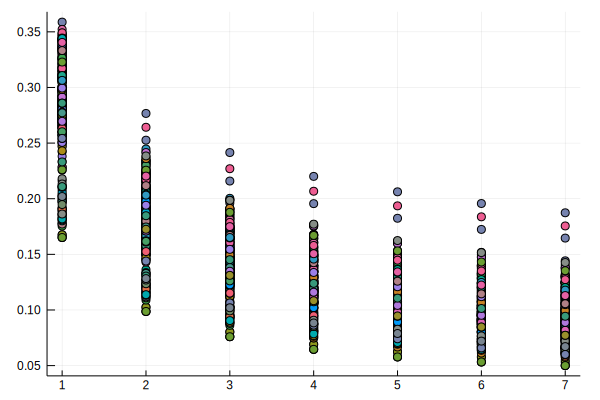

In [52]:
pp

In [54]:
xxx=[]
yyy=[]
gord1=[]
gord2=[]
for k in keys(hhsn)
    push!(xxx, k[2])
    push!(yyy, k[1])
    push!(gord1, hhsn[k][1])
    push!(gord2, hhsn[k][end])
end
    

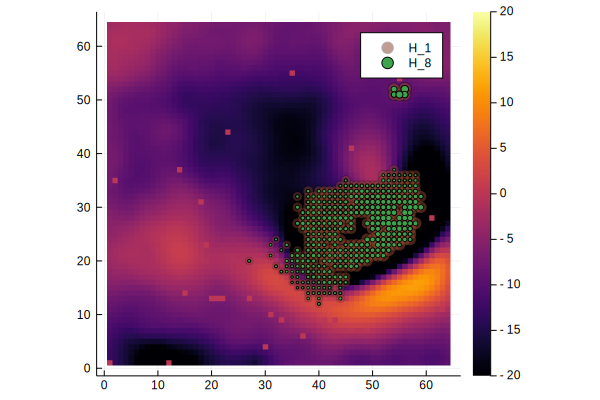

In [55]:
ppp=heatmap(csd[:,:,160], aspect_ratio=1, clims=(-20,20))
scatter!(xxx, yyy, markersize=gord1.*20, label="H_1", markeralpha=gord1)
scatter!(xxx, yyy, markersize=gord2.*20, label="H_8")


In [56]:
retr+lat

117

In [64]:
using LightGraphs, GraphPlot

In [70]:
using TikzGraphs

┌ Info: Precompiling TikzGraphs [b4f28e30-c73f-5eaf-a395-8a9db949a742]
└ @ Base loading.jl:1192


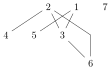

In [72]:
TikzGraphs.plot(arg)

In [65]:
arg=Graph(A)

{7, 6} undirected simple Int64 graph

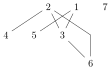

In [104]:
TikzGraphs.plot(arg)

In [106]:
rem_vertex!(arg, 5)

true

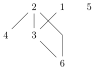

In [107]:
TikzGraphs.plot(arg)

In [85]:
arbol1=Graph(adja)

{39, 24} undirected simple Int64 graph

In [92]:
palos=edges(arbol1)

SimpleEdgeIter 24

In [102]:
nodos=collect(vertices(arbol1));


In [94]:
arbol1podado=Graph()

{0, 0} undirected simple Int64 graph

In [98]:
for q in palos 
    print(q)
    add_edge!(arbol1podado,q)
end

Edge 1 => 4Edge 1 => 5Edge 2 => 7Edge 2 => 8Edge 2 => 9Edge 3 => 10Edge 3 => 11Edge 3 => 12Edge 4 => 13Edge 4 => 14Edge 5 => 16Edge 5 => 17Edge 5 => 18Edge 7 => 22Edge 7 => 23Edge 8 => 25Edge 8 => 26Edge 8 => 27Edge 9 => 29Edge 9 => 30Edge 10 => 31Edge 11 => 35Edge 12 => 37Edge 12 => 39

In [100]:
palos[1]

MethodError: MethodError: no method matching getindex(::LightGraphs.SimpleGraphs.SimpleEdgeIter{SimpleGraph{Int64}}, ::Int64)

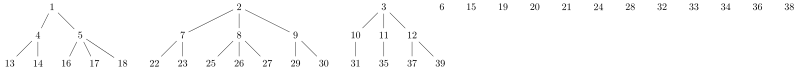

In [125]:
TikzGraphs.plot(arbol1)

In [56]:
max1=maximum(aar)
max8=maximum(bbr)

0.33574732277564123

In [59]:
for k in keys(hhsn)
    if hhsn[k][1]==min1
        print(k, " es el min de 1 bloque. ")
    elseif hhsn[k][1]==max1
        print(k, " es el max de 1 bloque. ")
    end
   if hhsn[k][8]==min8
        print(k, " es el min de 8 bloque. ")
    elseif hhsn[k][8]==max8
        print(k, " es el max de 8 bloque. ")
    end
end


[36, 54] es el max de 1 bloque. [24, 61] es el max de 8 bloque. [42, 51] es el min de 1 bloque. [42, 51] es el min de 8 bloque. 

In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [ ]:
allprobsn(xs, ss, 3)

In [ ]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

In [102]:
struct ONodo
    mesmo
end
a=ONodo(1)

ONodo(1)

In [101]:
?Nodo

search: Nodo unicodeplots UndefKeywordError ncodeunits QuoteNode invmod download



No documentation found.

# Summary

```
struct Nodo <: Any
```

# Fields

```
parent   :: Nodo
children :: Array{Nodo,1}
```


In [98]:
struct fobar
    fo
    bar
end

In [99]:
a=fobar(1,2)

fobar(1, 2)

In [46]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

(0.016129032258064516, 0.9556451612903226, 0.028225806451612902)

In [ ]:
heatmap(sumsym, aspect_ratio=1)

In [ ]:
?heatmap

In [68]:
a=[0,1]
n=[0, 1]
z=[1,1,0]
z2=[1,0,1]

3-element Array{Int64,1}:
 1
 0
 1

In [71]:
@time issubvec(a, z2)

  0.000008 seconds (9 allocations: 512 bytes)


true

In [72]:
@inbounds

LoadError: MethodError: no method matching @inbounds(::LineNumberNode, ::Module)
Closest candidates are:
  @inbounds(::LineNumberNode, ::Module, !Matched::Any) at essentials.jl:538

In [60]:
as=string(a)

"[0, 1]"